In [1]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np

from dpp import DPP

from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from dpp import DPP
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair

from experiments.make_flow import make_wrapped_normflow_realnvp
from tqdm import tqdm

import seaborn as sns
sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 2.0)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25

## Setup Target distribution

In [2]:
dim = 2
seed = 0

In [3]:
torch.manual_seed(0)  # seed of 0 for GMM problem
target = DPP(dim=dim, use_gpu=False, data = 'D_Kspipi_SDP_even.npy', true_expectation_estimation_n_samples=int(1e5))

In [4]:
import os
os.environ["PATH"] = "/Library/TeX/texbin:" + os.environ["PATH"]

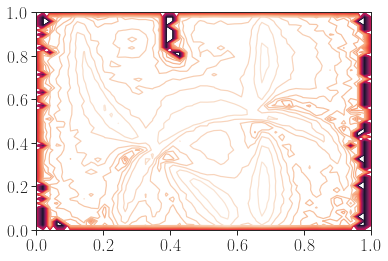

In [5]:
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = ((0,1))
plot_contours(target.log_prob, bounds = plotting_bounds, n_contour_levels=60, ax=ax, grid_width_n_points=50)
target.to("cuda")

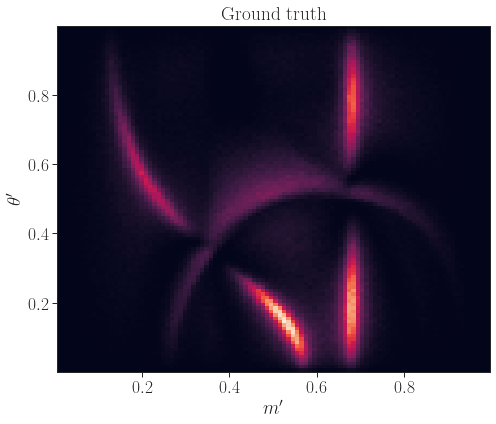

In [6]:
samples_gt = target.sample(1000000)
samples_gt = samples_gt.detach().numpy()

fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.hist2d(samples_gt[:,0], samples_gt[:,1], 100)
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
ax.set_title(r'$\mathrm{Ground}$ $\mathrm{truth}$')
fig.tight_layout()

## Reinitialize FAB model

In [7]:
## Define the flow
n_flow_layers = 40
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096*2
n_iterations = 2000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 50 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 20
metropolis_step_size = 0.15
# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [8]:
if use_64_bit:
    torch.set_default_dtype(torch.float64)
    target = target.double()
    print(f"running with 64 bit")

running with 64 bit


### Setup flow

In [9]:
# Define the flow
flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                     layer_nodes_per_dim=layer_nodes_per_dim,
                                     act_norm=False)

/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/_tensor.py:663: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1925.)
  LU, pivots, infos = torch._lu_with_info(


In [10]:
# Define the transistion operator
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltonianMonteCarlo(
            n_ais_intermediate_distributions=n_intermediate_distributions,
            dim=dim,
            base_log_prob=flow.log_prob,
            target_log_prob=target.log_prob,
            alpha=alpha,
            p_target=p_target,
        n_outer=1,
        epsilon=1.0, L=5)
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(            
        n_ais_intermediate_distributions=n_intermediate_distributions,
        dim=dim,
        base_log_prob=flow.log_prob,
        target_log_prob=target.log_prob,
        p_target=p_target,
        alpha=alpha,
        n_updates=1,
        adjust_step_size=False,
        max_step_size=metropolis_step_size, # the same for all metropolis steps 
        min_step_size=metropolis_step_size,
        eval_mode=True)
else:
    raise NotImplementedError

In [11]:
# Define the FAB model
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator,
                     alpha=alpha)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
logger = ListLogger(save=False) # save training history

In [12]:
# Setup buffer.
def initial_sampler():
  # fill replay buffer using initialised model and AIS.
    point, log_w = fab_model.annealed_importance_sampler.sample_and_log_weights(
            batch_size, logging=False)
    return point.x, log_w, point.log_q
buffer = PrioritisedReplayBuffer(dim=dim, max_length=maximum_buffer_length,
                      min_sample_length=min_buffer_length,
                      initial_sampler=initial_sampler)

In [13]:
def plot(fab_model, n_samples = 128):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[2], n_contour_levels=50, grid_width_n_points=200)
    target.to("cuda")

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,)).detach()
    plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0].x
    plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
    
    # plot buffer samples
    samples_buffer = buffer.sample(n_samples)[0].detach()
    plot_marginal_pair(samples_buffer, ax=axs[2], bounds=plotting_bounds)
    
    axs[0].set_title("flow samples")
    axs[1].set_title("ais samples")
    axs[2].set_title("buffer samples")
    plt.show()
    return [fig]

In [14]:
# Setup trainer.
trainer = PrioritisedBufferTrainer(model=fab_model, optimizer=optimizer, 
              logger=logger, plot=plot,
              buffer=buffer, 
              n_batches_buffer_sampling=n_batches_buffer_sampling,
              max_gradient_norm=max_gradient_norm,
              alpha=alpha,
              w_adjust_max_clip=None)

## Train model

loss: 1.567543165129861, ess base: 0.03067703698814687,ess ais: 0.023305721202439886:   0%|          | 0/2000 [00:10<?, ?it/s]

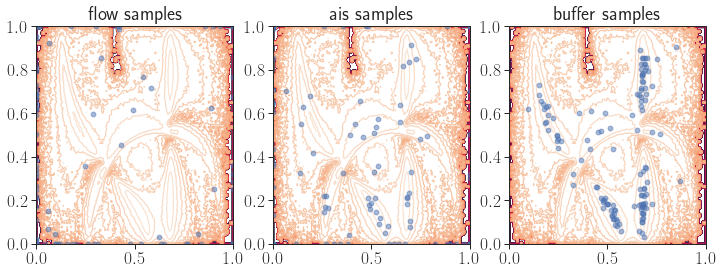

loss: -0.18703600119136338, ess base: 0.30258660045347086,ess ais: 0.24073066932485787:   2%|▏         | 40/2000 [04:46<3:57:39,  7.28s/it]   

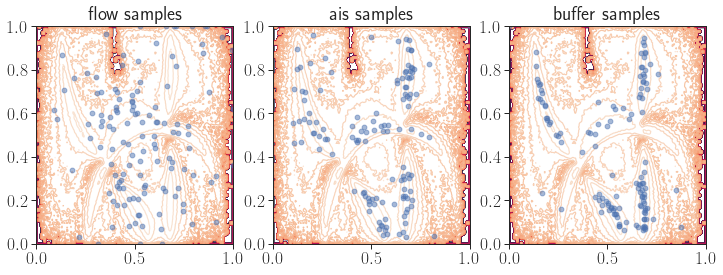

loss: -0.337142264043398, ess base: 0.40190922865764733,ess ais: 0.32414762884456:   4%|▍         | 81/2000 [09:39<4:04:04,  7.63s/it]       

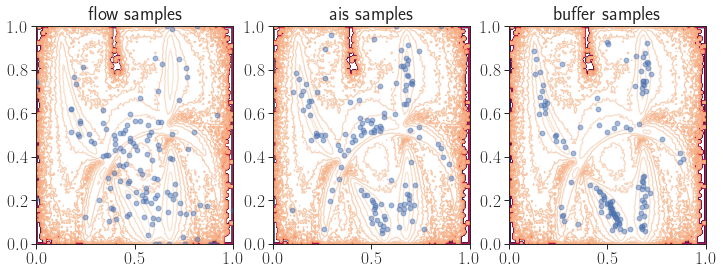

loss: -0.42070267480623885, ess base: 0.45880301950526675,ess ais: 0.4507991578203554:   6%|▌         | 122/2000 [22:41<29:27:49, 56.48s/it] 

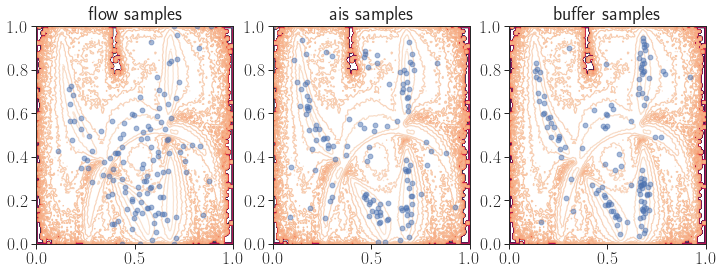

loss: -0.5291149595640428, ess base: 0.5220192455024176,ess ais: 0.49733817670943575:   8%|▊         | 163/2000 [30:32<3:27:11,  6.77s/it]  

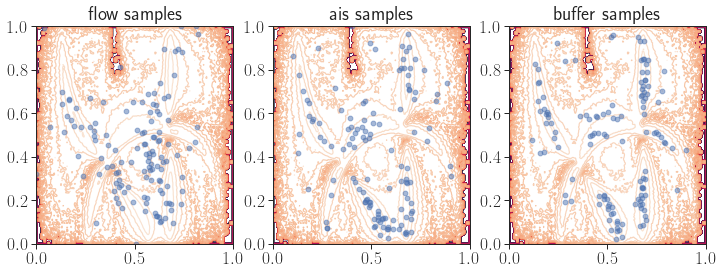

loss: -0.5800645918358897, ess base: 0.5784511809837032,ess ais: 0.578747155129409:  10%|█         | 203/2000 [35:21<2:58:00,  5.94s/it]    

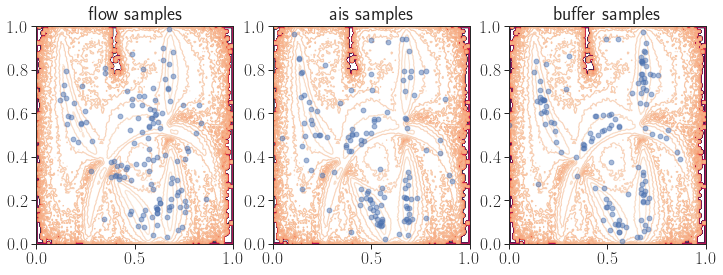

loss: -0.62003891774503, ess base: 0.6653776072537526,ess ais: 0.6585881623140747:  12%|█▏        | 244/2000 [39:55<3:39:16,  7.49s/it]     

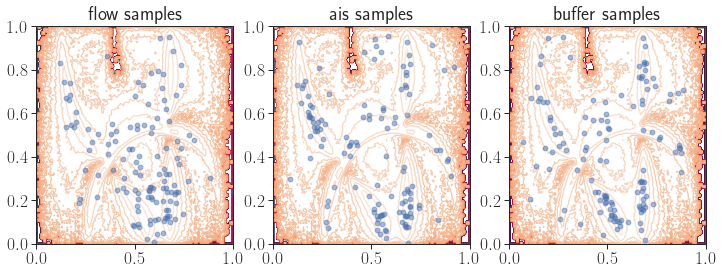

loss: -0.6212339319718607, ess base: 0.7053151927453513,ess ais: 0.7316700612890241:  14%|█▍        | 285/2000 [48:57<6:10:51, 12.97s/it]      

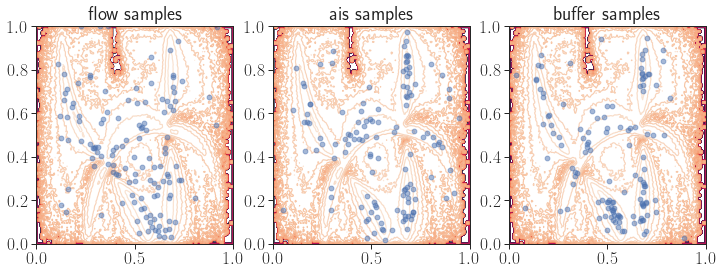

loss: -0.6993371582437345, ess base: 0.7480135101525426,ess ais: 0.7909482365629501:  16%|█▋        | 326/2000 [2:00:16<3:12:18,  6.89s/it]    

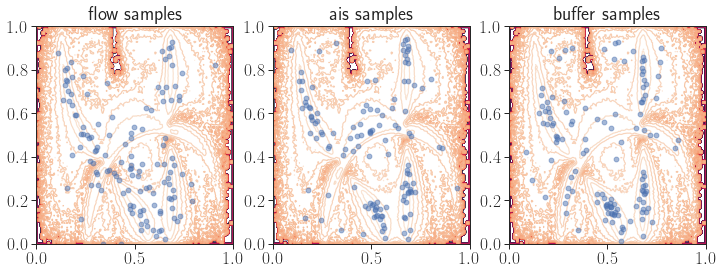

loss: -0.7305795529922137, ess base: 0.7721735587536193,ess ais: 0.8100740551912591:  18%|█▊        | 367/2000 [2:05:03<3:01:56,  6.68s/it]    

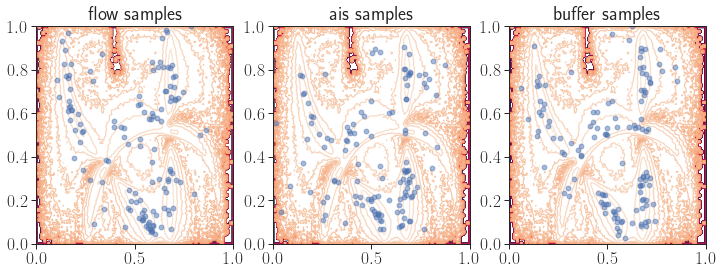

loss: -0.7067956993473078, ess base: 0.7814496695492542,ess ais: 0.8243120936684395:  19%|█▉        | 377/2000 [2:06:16<9:03:38, 20.10s/it]


KeyboardInterrupt: 

In [15]:
# Now run!
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval =  None, eval_batch_size=eval_batch_size, save=False)  # note that the progress bar during training prints ESS w.r.t p^2/q. 

In [16]:
# # Load in the state dictionary (layer weights, etc.)
# #PATH = './FAB_D_pipipi_SDP_6.pth'
# PATH = './FAB_Dbar_pipipi_CPV_SDP_3.pth'
# flow.load_state_dict(torch.load(PATH))
# flow.eval()

In [17]:
# Check if GPU is available
if torch.cuda.is_available():
    flow.cuda()
    transition_operator.cuda()
    target.to("cuda")
    print(f"Running with GPU")

## Ground truth

## Flow

In [24]:
n_samples = 10000
samples_flow = []
n = 0
for i in tqdm(range(100), ncols = 100):
    sample_flow = fab_model.flow.sample((n_samples,)).detach().numpy()
    #for j in range(n_samples):
        #if sample_flow[j,0] > 1.0 or sample_flow[j,0] < 0.0 or sample_flow[j,1] > 1.0 or sample_flow[j,1] < 0.0:
            #print('Element out of range.')
            #n+=1
    samples_flow.append(sample_flow)
print(n, 'elements out of range.')

100%|█████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]

0 elements out of range.


In [19]:
samples_flow = np.array(samples_flow)
print(samples_flow.shape)
samples_flow = np.reshape(samples_flow, (samples_flow.shape[0] * samples_flow.shape[1], 2))
print(samples_flow.shape)

(100, 10000, 2)
(1000000, 2)


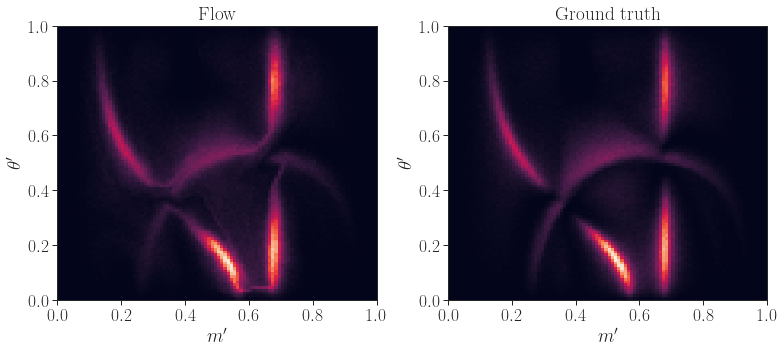

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
H_flow, xedges, yedges, im = ax1.hist2d(samples_flow[:,0], samples_flow[:,1], 100, range = [[0,1], [0,1]])
H_gt, xedges, yedges, im = ax2.hist2d(samples_gt[:,0], samples_gt[:,1], bins = (xedges, yedges))
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Flow}$')
ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Ground}$ $\mathrm{truth}$')
fig.tight_layout()

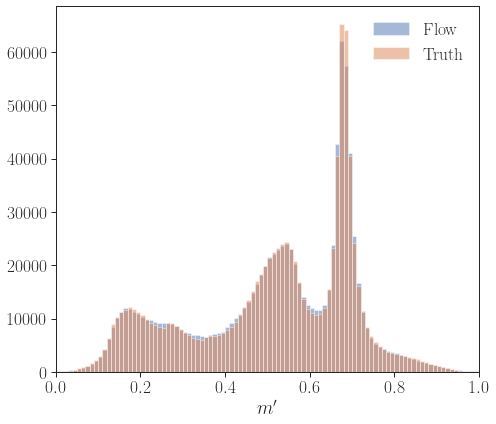

In [21]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.hist(samples_flow[:,0], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Flow}$')
ax.hist(samples_gt[:,0], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Truth}$')
ax.set_xlim(0,1)
ax.set_xlabel(r"$m'$")
ax.legend(frameon=False)
fig.tight_layout()

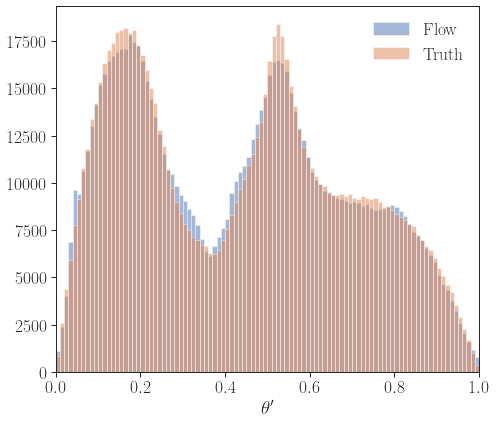

In [22]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.hist(samples_flow[:,1], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Flow}$')
ax.hist(samples_gt[:,1], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Truth}$')
ax.set_xlim(0,1)
ax.set_xlabel(r"$\theta'$")
ax.legend(frameon=False)
fig.tight_layout()

## Flow with AIS

In [25]:
n_samples = 10000
samples_ais = []
for i in tqdm(range(100), ncols = 100):
    sample_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples, logging=False)[0].x
    # Check that samples are in valid range
    for j in range(n_samples):
        if sample_ais[j,0] > 1.0 or sample_ais[j,0] < 0.0 or sample_ais[j,1] > 1.0 or sample_ais[j,1] < 0.0:
            sample_ais_i = sample_ais[j]
            while sample_ais_i[0] < 1.0 and sample_ais_i[0] > 0.0 and sample_ais_i[1] < 1.0 and sample_ais_i[1] > 0.0:
                sample_ais_i = fab_model.annealed_importance_sampler.sample_and_log_weights(1, logging=False)[0].x
            sample_ais[j] = sample_ais_i[0] 
        #print(sample_ais)
    samples_ais.append(sample_ais.detach().numpy())

  7%|████▍                                                          | 7/100 [00:27<06:06,  3.94s/it]


KeyboardInterrupt: 

In [26]:
samples_ais = np.array(samples_ais)
print(samples_ais.shape)
samples_ais = np.reshape(samples_ais, (samples_ais.shape[0] * samples_ais.shape[1], 2))
print(samples_ais.shape)

(100, 10000, 2)
(1000000, 2)


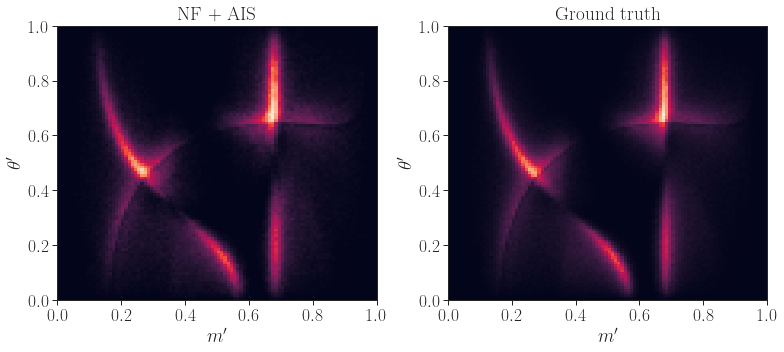

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
H_ais, xedges, yedges, im = ax1.hist2d(samples_ais[:,0], samples_ais[:,1], 100, range = [[0,1], [0,1]])
ax2.hist2d(samples_gt[:,0], samples_gt[:,1], bins = (xedges, yedges))
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{NF}$ $+$ $\mathrm{AIS}$')
ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Ground}$ $\mathrm{truth}$')
fig.tight_layout()
fig.savefig(r'NF_AIS_vs_truth.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

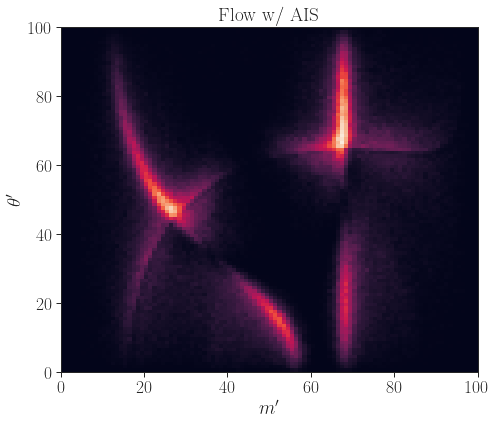

In [28]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.pcolormesh(H_ais.T)
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
ax.set_title(r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$')
fig.tight_layout()

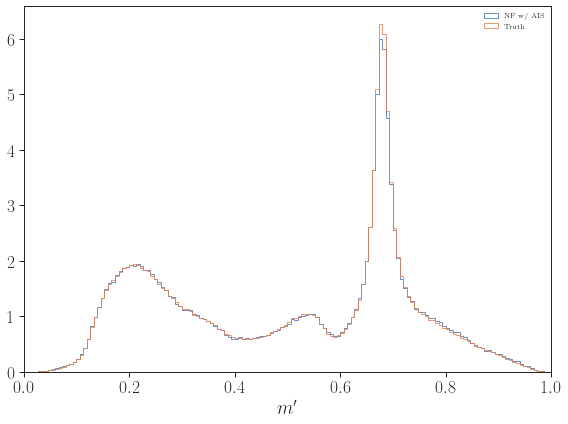

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
counts, edges, _ = ax.hist(samples_ais[:,0], 150, range = [0,1], histtype = 'step', label = r'$\mathrm{NF}$ $\mathrm{w/}$ $\mathrm{AIS}$', density=True)
ax.hist(samples_gt[:,0], bins = edges, range = [0,1], histtype = 'step', label = r'$\mathrm{Truth}$', density=True)
#ax.hist(samples_flow[:,0], 100, range = [0,1], histtype = 'step', label = r'$\mathrm{Flow}$', density=True)
ax.set_xlim(0,1)
ax.set_xlabel(r"$m'$")
ax.legend(frameon=False, fontsize = 'x-small')
fig.tight_layout()
fig.savefig(r'NF_AIS_mp_vs_truth.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

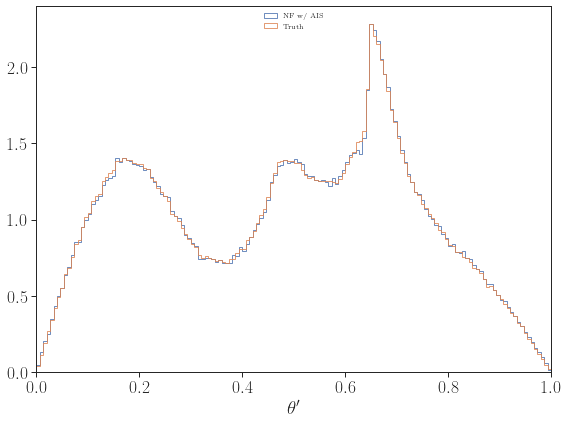

In [30]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
counts, edges, _ = ax.hist(samples_ais[:,1], 150, range = [0,1], histtype = 'step', label = r'$\mathrm{NF}$ $\mathrm{w/}$ $\mathrm{AIS}$', density = True)
ax.hist(samples_gt[:,1], bins = edges, range = [0,1], histtype = 'step', label = r'$\mathrm{Truth}$', density = True)
#ax.hist(samples_flow[:,1], 100, range = [0,1], histtype = 'step', label = r'$\mathrm{Flow}$')
ax.set_xlim(0,1)
ax.set_xlabel(r"$\theta'$")
ax.legend(frameon=False, fontsize = 'x-small', loc = 'upper center')
fig.tight_layout()
fig.savefig(r'NF_AIS_thetap_vs_truth.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

## Flow with AIS reweighed

In [32]:
n_samples = 10000
samples_ais_weighted = []
weights = []
for _ in tqdm(range(100), ncols = 100):
    sample_ais_weight, weight = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples, logging=False)
    # Check that each sampled point is within the physical range (0,1), otherwise resample and replace
    #for j in range(n_samples):
    #    if sample_ais_weight.x[j,0] > 1.0 or sample_ais_weight.x[j,0] < 0.0 or sample_ais_weight.x[j,1] > 1.0 or sample_ais_weight.x[j,1] < 0.0:
    #        sample_ais_weight_i = sample_ais_weight[j]
    #        weight_i = weight[j]
    #        while sample_ais_weight_i.x[0] < 1.0 and sample_ais_weight_i.x[0] > 0.0 and sample_ais_weight_i.x[1] < 1.0 and sample_ais_weight_i.x[1] > 0.0:
    #            sample_ais_weight_i, weight_i = fab_model.annealed_importance_sampler.sample_and_log_weights(1, logging=False)
    #        sample_ais_weight.x[j] = sample_ais_weight_i.x[0]
    #        weight[j] = weight_i
    samples_ais_weighted.append(sample_ais_weight.x)
    weights.append(np.exp(weight).numpy())

100%|█████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


In [33]:
# Convert each tensor in samples_ais_weighted to a NumPy array
samples_ais_weighted = [sample.detach().numpy() for sample in samples_ais_weighted]

# Convert to numpy array
samples_ais_weighted = np.array(samples_ais_weighted)
print(samples_ais_weighted.shape)

# Flatten to desired shape
samples_ais_weighted = np.reshape(samples_ais_weighted, (samples_ais_weighted.shape[0] * samples_ais_weighted.shape[1], 2))
print(samples_ais_weighted.shape)

# Convert weights to numpy array and flatten
weights = np.array(weights).flatten()
print(weights.shape)

(100, 10000, 2)
(1000000, 2)
(1000000,)


In [33]:
# # Convert to numpy array
# samples_ais_weighted = np.array(samples_ais_weighted)
# print(samples_ais_weighted.shape)
# # Flatten to desired shape
# samples_ais_weighted = np.reshape(samples_ais_weighted, (samples_ais_weighted.shape[0] * samples_ais_weighted.shape[1], 2))
# print(samples_ais_weighted.shape)
# weights = np.array(weights).flatten()
# print(weights.shape)

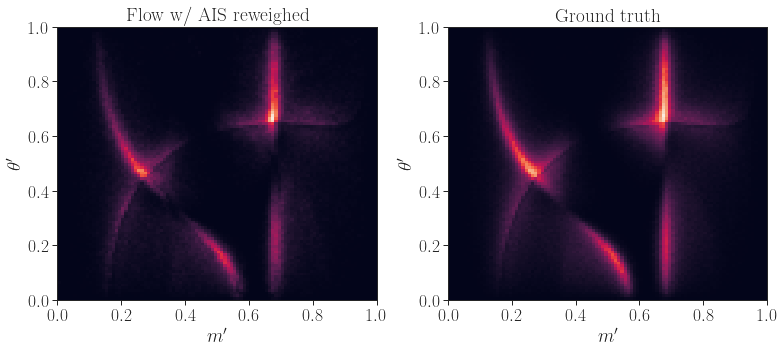

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
H, xedges, yedges, im = ax1.hist2d(samples_ais_weighted[:,0], samples_ais_weighted[:,1], 100, range = [[0,1],[0,1]], weights = weights, density = True)
ax2.hist2d(samples_gt[:,0], samples_gt[:,1], bins = (xedges, yedges), density = True)
#ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$ $\mathrm{reweighed}$')
ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Ground}$ $\mathrm{truth}$')
fig.tight_layout()

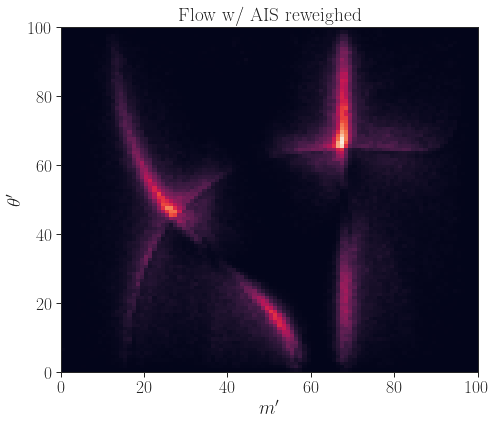

In [35]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.pcolormesh(H.T)
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
ax.set_title(r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$ $\mathrm{reweighed}$')
fig.tight_layout()

In [36]:
mp = np.array([np.sum(H[i]) for i in range(len(H[0]))])
thetap = np.array([np.sum(H[:,i]) for i in range(len(H[0]))])

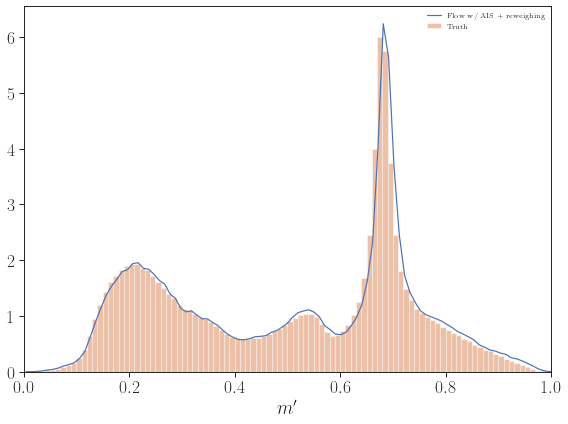

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
x = np.linspace(0.005,1.005,100)
ax.plot(x, mp / 100, label = r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$ $+$ $\mathrm{reweighing}$')
ax.hist(samples_gt[:,0], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Truth}$', density = True)
ax.set_xlim(0,1)
ax.set_xlabel(r"$m'$")
ax.legend(frameon=False, fontsize = 'x-small')
fig.tight_layout()

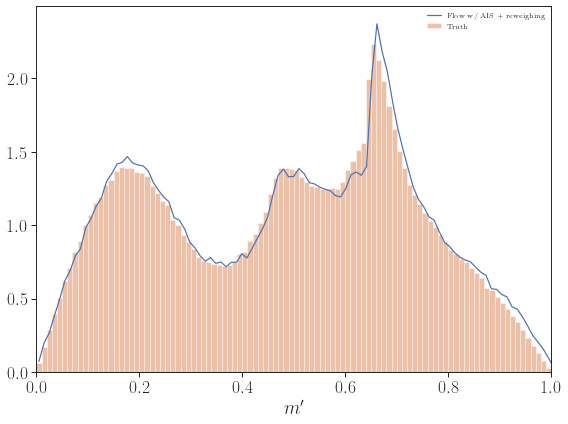

In [38]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
x = np.linspace(0.005,1.005,100)
ax.plot(x, thetap / 100, label = r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$ $+$ $\mathrm{reweighing}$')
ax.hist(samples_gt[:,1], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Truth}$', density = True)
ax.set_xlim(0,1)
ax.set_xlabel(r"$m'$")
ax.legend(frameon=False, fontsize = 'x-small')
fig.tight_layout()

In [39]:
def get_density(flow, x):
    """
    Compute the probability density at x using the trained flow.
    
    Parameters:
      flow: the normalizing flow model (an instance of a normflows flow)
      x: a torch tensor of shape (batch_size, dim)
    
    Returns:
      density: a torch tensor of the probability density at x
    """
    # Ensure no gradients are computed during evaluation
    with torch.no_grad():
        log_density = flow.log_prob(x)
        density = torch.exp(log_density)
    return density

# Example usage:
# x_query is a point (or batch of points) in the data space (with dimension 'dim')
x_query = torch.tensor([[0.5, 0.3]], dtype=torch.get_default_dtype()).to(next(flow.parameters()).device)
density_at_x = get_density(flow, x_query)
print("Density at x_query:", density_at_x)


Density at x_query: tensor([0.0425])


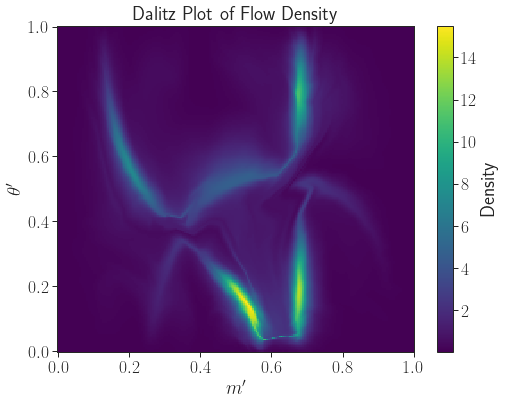

In [26]:
# Assume get_density(flow, x) is defined as:
def get_density(flow, x):
    with torch.no_grad():
        log_density = flow.log_prob(x)
        density = torch.exp(log_density)
    return density

# Define grid resolution
n_grid = 200

# Create 1D grids for theta' and m'
# (Assuming the original flow was trained with input ordering [θ′, m′],
# but in fact the first coordinate is m' and the second is θ')
theta_vals = torch.linspace(0, 1, n_grid)
m_vals = torch.linspace(0, 1, n_grid)

# Create a meshgrid. Here, rows correspond to theta' and columns to m'
Theta, M = torch.meshgrid(theta_vals, m_vals, indexing='ij')

# Stack the grid points into a (n_grid*n_grid, 2) tensor.
# If our intended interpretation is that the first coordinate is actually m'
# and the second is θ', we can either swap the stacking order or adjust in the plot.
# Here we keep stacking as before:
grid_points = torch.stack([Theta.flatten(), M.flatten()], dim=1)

# Make sure grid_points are on the same device and dtype as the flow parameters.
device = next(flow.parameters()).device
grid_points = grid_points.to(device).double()

# Compute density at each grid point.
density = get_density(flow, grid_points)  # shape: (n_grid*n_grid,)
density_grid = density.view(n_grid, n_grid).cpu().numpy()

# Now, since our first coordinate in grid_points is actually m' and the second is θ',
# we swap the axes when plotting (by transposing density_grid).
plt.figure(figsize=(8, 6))
plt.pcolormesh(theta_vals.cpu().numpy(), m_vals.cpu().numpy(), density_grid.T, shading='auto', cmap='viridis')
plt.xlabel(r"$m'$")      # x-axis now corresponds to m'
plt.ylabel(r"$\theta'$")  # y-axis now corresponds to θ'
plt.title("Dalitz Plot of Flow Density")
plt.colorbar(label="Density")
plt.show()


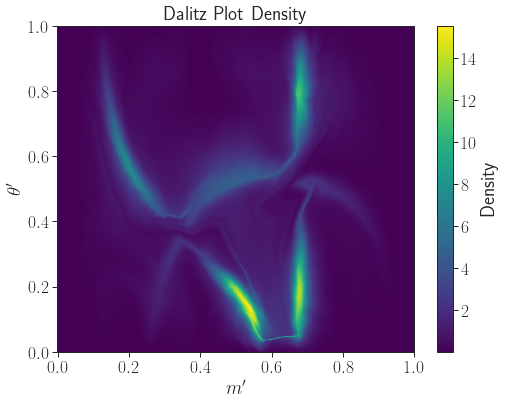

In [27]:
def get_density(flow, x):
    with torch.no_grad():
        log_density = flow.log_prob(x)
        return torch.exp(log_density)

def save_density(flow, output_filename, n_grid=1000):
    # 1. Create the grid
    theta_vals = torch.linspace(0, 1, n_grid)
    m_vals = torch.linspace(0, 1, n_grid)
    Theta, M = torch.meshgrid(theta_vals, m_vals, indexing='ij')
    grid_points = torch.stack([Theta.flatten(), M.flatten()], dim=1)

    # 2. Ensure same device/dtype as flow
    device = next(flow.parameters()).device
    grid_points = grid_points.to(device).double()

    # 3. Compute the density
    density = get_density(flow, grid_points)  # shape: (n_grid*n_grid,)
    density_grid = density.view(n_grid, n_grid).cpu().numpy()

    # 4. Save to disk
    np.save(output_filename, density_grid)

    # 5. (Optional) Plot
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(m_vals.cpu().numpy(), theta_vals.cpu().numpy(), density_grid.T, 
                   shading='auto', cmap='viridis')
    plt.xlabel(r"$m'$")
    plt.ylabel(r"$\theta'$")
    plt.title("Dalitz Plot Density")
    plt.colorbar(label="Density")
    plt.show()

flow_d0 = flow # your trained normalizing flow for D^0
save_density(flow_d0, "even-density.npy", n_grid=1000)